## We select from the dataset only the position on each 20th timestep
## We choose a window of 6 time steps
## We want to learn 5 steps and predict 1 steps.
## Each step = 20 seconds

In [1]:
import sys
sys.path.append('../')

import pandas as pd
import numpy as np
import keras
from datetime import datetime, timedelta
from sklearn.preprocessing import StandardScaler
from configs.utils_2 import windowing, windowing_array
from sklearn.model_selection import train_test_split
from configs.utils_2 import split_sequence

%load_ext autoreload
%autoreload 2

2024-03-27 21:29:47.153979: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-03-27 21:29:47.181168: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-27 21:29:47.181189: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-27 21:29:47.181980: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-03-27 21:29:47.186728: I tensorflow/core/platform/cpu_feature_guar

### Data Exploration

In [2]:
csv_input = pd.read_csv('../data/files/dataset_trajectory.csv')
data = csv_input

In [3]:
# show head
print(data.shape)
data.head()

(2298600, 6)


pos.x     pos.y     pos.z   heading  velocity  weather
0 -77.030670 -1.283448  0.294200 -1.568362  7.056001        2
1 -77.030670 -1.283448  0.061311 -1.568362  7.172558        2
2 -77.029778 -1.283539 -0.030319 -1.568443  1.053028        2
3 -77.028854 -1.283728 -0.023681 -1.568593  0.883579        2
4 -77.008575 -1.288779  0.003869 -1.572756  1.548891        2

In [4]:
# Remove rows with any NaN values
data = data.dropna()
print(len(data))

1315800


### Time

In [5]:
## Adding date time
# Start datetime
start_datetime = datetime(2009, 1, 1, 0, 0, 0)

# Generate datetime column with incrementing seconds
num_rows = len(data)
seconds_increment = timedelta(seconds=1)

date_times = [start_datetime + i * seconds_increment for i in range(num_rows)]

# Add datetime column to DataFrame
data['Date Time'] = date_times

In [6]:
date_time = pd.to_datetime(data.pop('Date Time'), format='%d.%m.%Y %H:%M:%S')
timestamp_s = date_time.map(pd.Timestamp.timestamp)
minute = 60
data['Minute sin'] = np.sin(timestamp_s * (2 * np.pi / minute))
data['Minute cos'] = np.cos(timestamp_s * (2 * np.pi / minute))

In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1315800 entries, 0 to 1315799
Data columns (total 8 columns):
 #   Column      Non-Null Count    Dtype  
---  ------      --------------    -----  
 0   pos.x       1315800 non-null  float64
 1   pos.y       1315800 non-null  float64
 2   pos.z       1315800 non-null  float64
 3   heading     1315800 non-null  float64
 4   velocity    1315800 non-null  float64
 5   weather     1315800 non-null  int64  
 6   Minute sin  1315800 non-null  float64
 7   Minute cos  1315800 non-null  float64
dtypes: float64(7), int64(1)
memory usage: 80.3 MB


In [8]:
data.head(21)

pos.x     pos.y     pos.z   heading   velocity  weather    Minute sin  \
0  -77.030670 -1.283448  0.294200 -1.568362   7.056001        2 -1.792514e-08   
1  -77.030670 -1.283448  0.061311 -1.568362   7.172558        2  1.045284e-01   
2  -77.029778 -1.283539 -0.030319 -1.568443   1.053028        2  2.079117e-01   
3  -77.028854 -1.283728 -0.023681 -1.568593   0.883579        2  3.090170e-01   
4  -77.008575 -1.288779  0.003869 -1.572756   1.548891        2  4.067366e-01   
5  -76.958603 -1.300489  0.025596 -1.580881   2.477841        2  5.000000e-01   
6  -76.877892 -1.318563  0.037388 -1.593716   3.679502        2  5.877852e-01   
7  -76.765839 -1.343634  0.042167 -1.609957   4.698247        2  6.691306e-01   
8  -76.621765 -1.376469  0.043385 -1.629386   5.936289        2  7.431448e-01   
9  -76.440231 -1.407857  0.043267 -1.643464   7.269622        2  8.090170e-01   
10 -76.220856 -1.436090  0.042877 -1.651711   8.587500        2  8.660254e-01   
11 -75.964699 -1.468136  0.042575 -1.659471   9.945355        2  9.135455e-01   
12 -75.669510 -1.505595  0.042410 -1.667132  11.423551        2  9.510565e-01   
13 -75.331734 -1.548945  0.042341 -1.674400  13.000433        2  9.781476e-01   
14 -74.950996 -1.598338  0.042322 -1.681028  14.545625        2  9.945219e-01   
15 -74.527924 -1.653784  0.042323 -1.686812  16.064592        2  1.000000e+00   
16 -74.063225 -1.715250  0.042329 -1.691677  17.555398        2  9.945219e-01   
17 -73.557800 -1.782584  0.042560 -1.695655  19.193598        2  9.781476e-01   
18 -73.031967 -1.852972  0.042667 -1.698542  19.274586        2  9.510565e-01   
19 -72.502975 -1.924258  0.042645 -1.700950  19.602346        2  9.135455e-01   
20 -71.958855 -1.998021  0.042595 -1.702724  20.223438        2  8.660254e-01   

      Minute cos  
0   1.000000e+00  
1   9.945219e-01  
2   9.781476e-01  
3   9.510565e-01  
4   9.135455e-01  
5   8.660254e-01  
6   8.090170e-01  
7   7.431448e-01  
8   6.691306e-01  
9   5.877853e-01  
10  5.000000e-01  
11  4.067367e-01  
12  3.090170e-01  
13  2.079117e-01  
14  1.045285e-01  
15  4.016074e-09  
16 -1.045284e-01  
17 -2.079117e-01  
18 -3.090170e-01  
19 -4.067366e-01  
20 -5.000000e-01

In [9]:
temp = data

### Sub-sampling the data

We start by sub-sampling the data from 1 second intervals to 20 seconds intervals

In [10]:
# Starting from index 20 take every 20th record.
data = data[20::20]

In [11]:
# show head
print(data.shape)
data.head()

(65789, 8)


pos.x     pos.y     pos.z   heading   velocity  weather  \
20  -71.958855 -1.998021  0.042595 -1.702724  20.223438        2   
40  -62.348705 -2.540402  0.042411 -1.598702  15.414865        2   
60  -50.229328 -2.648856  0.072671 -1.573244  28.381561        2   
80  -34.260929 -2.631236  0.041451 -1.569127  28.951020        2   
100 -18.290413 -2.592627  0.042571 -1.568653  28.908465        2   

       Minute sin  Minute cos  
20   8.660254e-01        -0.5  
40  -8.660254e-01        -0.5  
60  -6.992355e-09         1.0  
80   8.660254e-01        -0.5  
100 -8.660254e-01        -0.5

In [12]:
data = data.head(65784)

### Windowing
We choose a window of 6 time steps
We want to learn 5 steps and predict 1 steps.

In [13]:
window_size = 6
grouped_data = windowing_array(data, window_size)

In [14]:
print(len(grouped_data))
print(len(grouped_data[0]))
print(len(grouped_data[0][0]))

10964
6
8


### Slice and Split sequence 

In [15]:
x_train_init, x_test_init = train_test_split(grouped_data, shuffle=False, test_size=0.2)

In [16]:
x_train_init.shape, x_test_init.shape

((8771, 6, 8), (2193, 6, 8))

In [17]:
## slipt x_train_init to x_train, y_train, y_train_shifted_by_one

x_train, y_train, y_train_shifted_by_one = split_sequence(x_train_init)

In [18]:
x_train.shape, y_train.shape

((8771, 5, 8), (8771, 1, 8))

In [19]:
## First Let's start with predict only one input
#y_train = y_train[:,:,:1]

## Now let's try to predict two inputs (posx and posy)
y_train = y_train[:,:,:2]

In [20]:
y_train.shape

(8771, 1, 2)

In [ ]:
#y_train

In [21]:
y_train = y_train.reshape((-1, y_train.shape[-1]))

In [ ]:
#y_train

In [22]:
y_train.shape

(8771, 2)

In [23]:
## slipt x_test_init to y_test, y_test_shift_by_one, y_test
x_test, y_test, y_test_shifted_by_one = split_sequence(x_test_init)

In [24]:
x_test.shape, y_test.shape

((2193, 5, 8), (2193, 1, 8))

In [25]:
## First Let's start with predict only one input
#y_test = y_test[:,:,:1]

## Now let's try to predict two inputs (posx and posy)
y_test = y_test[:,:,:2]

In [26]:
y_test.shape

(2193, 1, 2)

In [27]:
y_test = y_test.reshape((-1, y_test.shape[-1]))

In [28]:
y_test.shape

(2193, 2)

### Model Configuration

In [29]:
# Define the input shape
input_shape = x_train.shape[1:]
input_shape

(5, 8)

In [30]:
# Define the output shape
outout_shape = y_train.shape[1:]
outout_shape

(2,)

In [31]:
# Define the output vector size
y_train_feature_nr = len(y_train[1])
output_seq_size = 2
output_features_nr=y_train_feature_nr * output_seq_size
output_features_nr

2

### Train and evaluate

In [44]:
from models.transformer import ITPF_Transformer


model = ITPF_Transformer()

In [45]:
model = model.build_model(
    input_shape=input_shape, 
    output_shape=outout_shape,
    output_features_nr=output_features_nr, 
    head_size=256,
    num_heads=4,
    ff_dim=4,
    num_transformer_blocks=4,
    mlp_units=[128],
    mlp_dropout=0.4,
    dropout=0.25
)

In [46]:
epochs = 150
batch_size = 32

callbacks = [
    keras.callbacks.ModelCheckpoint(
        "best_model_dest.keras", save_best_only=True, monitor="val_loss"
    ),
    keras.callbacks.ReduceLROnPlateau(
        monitor="val_loss", factor=0.5, patience=20, min_lr=0.0001
    ),
    keras.callbacks.EarlyStopping(monitor="val_loss", patience=50, verbose=1),
]
model.compile(
    optimizer="adam",
    loss=["mse"],
    metrics=['mae'],
)
history = model.fit(
    x_train,
    y_train,
    batch_size=batch_size,
    epochs=epochs,
    callbacks=callbacks,
    validation_split=0.2,
    verbose=1,
)

Epoch 1/150
220/220 [==============================] - 5s 10ms/step - loss: 2073.8826 - mae: 30.8626 - val_loss: 411.2325 - val_mae: 13.2222 - lr: 0.0010
Epoch 2/150
220/220 [==============================] - 2s 9ms/step - loss: 791.5935 - mae: 19.8733 - val_loss: 399.3315 - val_mae: 12.4663 - lr: 0.0010
Epoch 3/150
220/220 [==============================] - 2s 9ms/step - loss: 699.3226 - mae: 18.4027 - val_loss: 356.5161 - val_mae: 11.1427 - lr: 0.0010
Epoch 4/150
220/220 [==============================] - 2s 9ms/step - loss: 658.5726 - mae: 17.7067 - val_loss: 354.7312 - val_mae: 10.5522 - lr: 0.0010
Epoch 5/150
220/220 [==============================] - 2s 9ms/step - loss: 648.2043 - mae: 17.6017 - val_loss: 349.4073 - val_mae: 10.5617 - lr: 0.0010
Epoch 6/150
220/220 [==============================] - 2s 9ms/step - loss: 639.8808 - mae: 17.3711 - val_loss: 335.7955 - val_mae: 10.1575 - lr: 0.0010
Epoch 7/150
220/220 [==============================] - 2s 9ms/step - loss: 631.3904 - 

In [ ]:
#model.summary()

In [32]:
model = keras.models.load_model("best_model.keras")

test_loss, test_acc = model.evaluate(x_test, y_test)

print("Test accuracy", test_acc)
print("Test loss", test_loss)

69/69 [==============================] - 1s 5ms/step - loss: 124.2378 - mae: 6.6687
Test accuracy 6.668727397918701
Test loss 124.23783111572266


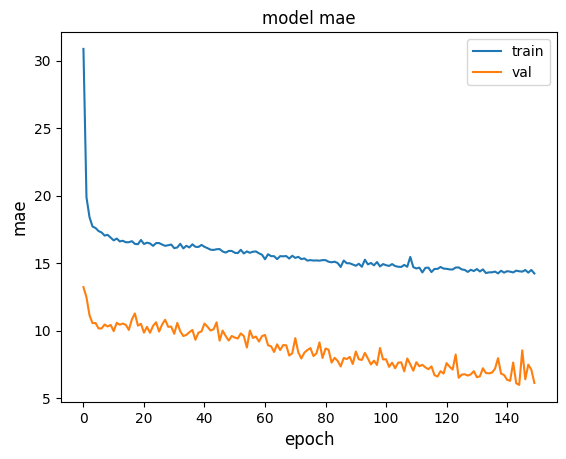

In [48]:
import matplotlib.pyplot as plt

metric = "mae"
plt.figure()
plt.plot(history.history[metric])
plt.plot(history.history["val_" + metric])
plt.title("model " + metric)
plt.ylabel(metric, fontsize="large")
plt.xlabel("epoch", fontsize="large")
plt.legend(["train", "val"], loc="best")
plt.show()
plt.close()

In [49]:
predictions = model.predict(x_test)

69/69 [==============================] - 0s 4ms/step


In [50]:
predictions.shape

(2193, 2)

Visualize some few predictions


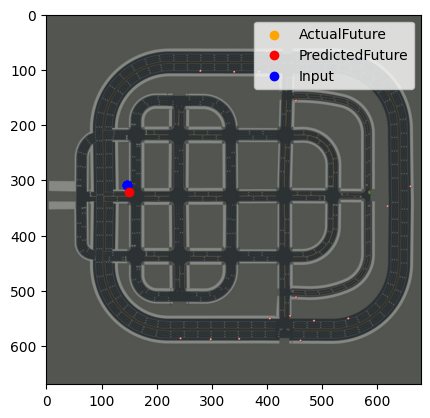

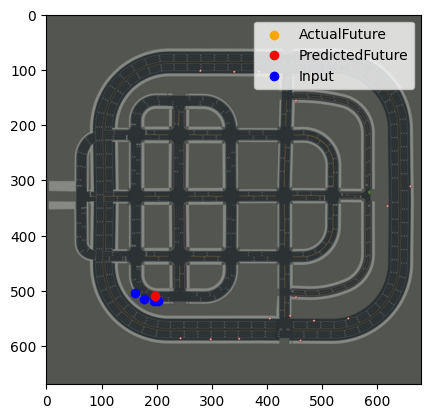

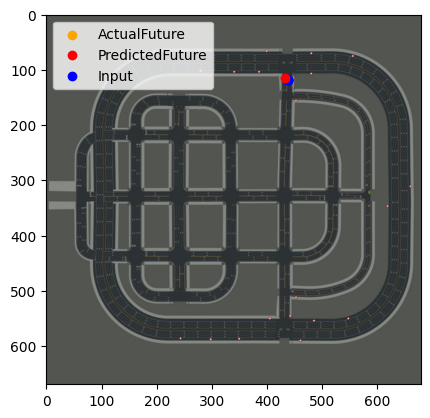

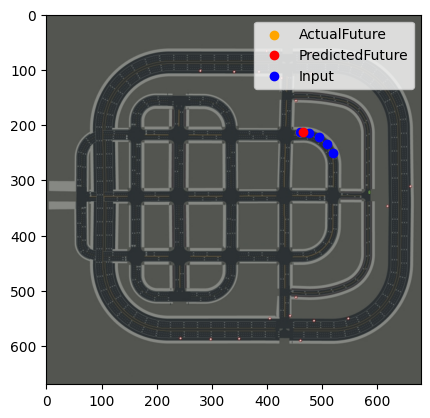

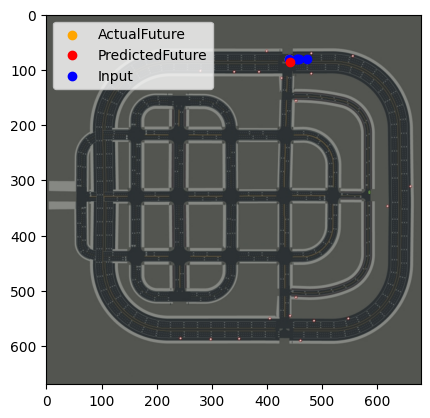

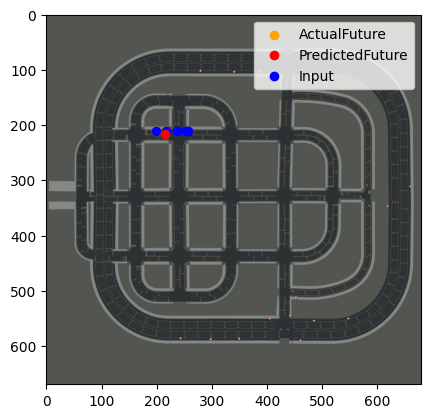

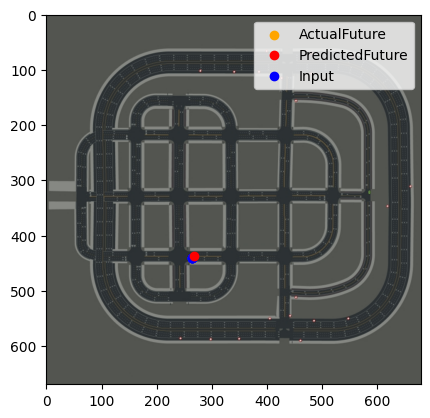

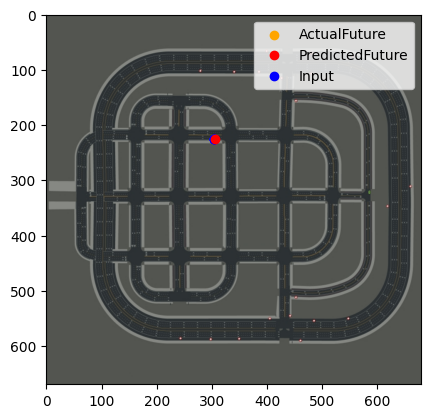

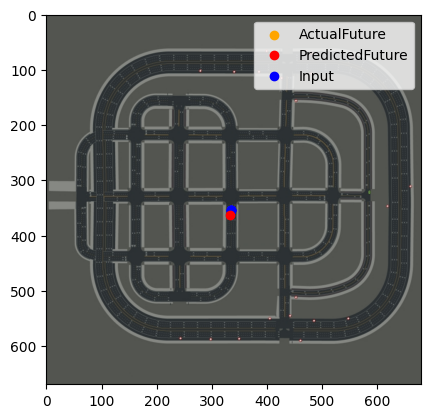

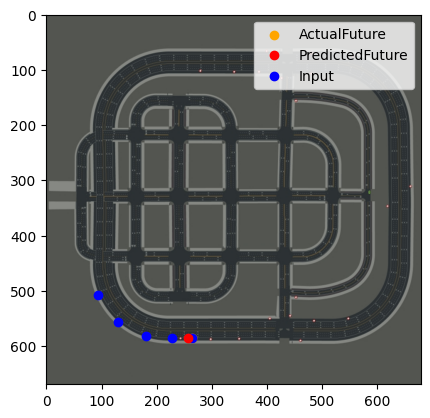

In [51]:
import random
from configs.utils_2 import plot_pred


print("Visualize some few predictions")

# After finding the best prediction, visualize it
if x_test is not None and y_test is not None and predictions is not None:
    # This visualization will now only show the best prediction example
    for item in range(0, 10):
        index = random.randint(0, len(x_test[:, :, :2]))
        plot_pred(x_test[:, :, :2][index], y_test[index], predictions[index])

## Explainer

### LIME

In [37]:
from lime import lime_tabular

In [38]:
explainer = lime_tabular.RecurrentTabularExplainer(
    x_train, 
    training_labels=y_train, 
    feature_names=["pos.x", "pos.y", "pos.z", "heading", "velocity", "weather", "Minute sin", "Minute cos"],
    discretize_continuous=True,
    class_names=['pos.x', 'pos.y'],
    discretizer='decile')

In [54]:
exp = explainer.explain_instance(x_test[0], model.predict, num_features=10, labels=(0,))
exp.show_in_notebook()

157/157 [==============================] - 1s 3ms/step


/home/ab000840/.local/lib/python3.10/site-packages/lime/lime_tabular.py:372: UserWarning: 
                    Prediction probabilties do not sum to 1, and
                    thus does not constitute a probability space.
                    Check that you classifier outputs probabilities
                    (Not log probabilities, or actual class predictions).
                    
  warnings.warn("""


In [55]:
exp = explainer.explain_instance(x_test[0], model.predict, num_features=10, labels=(1,))
exp.show_in_notebook()

157/157 [==============================] - 1s 3ms/step


/home/ab000840/.local/lib/python3.10/site-packages/lime/lime_tabular.py:372: UserWarning: 
                    Prediction probabilties do not sum to 1, and
                    thus does not constitute a probability space.
                    Check that you classifier outputs probabilities
                    (Not log probabilities, or actual class predictions).
                    
  warnings.warn("""


### Shape

In [56]:
import shap

# print the JS visualization code to the notebook
shap.initjs()

In [57]:
x_test_0 = x_test[0]
x_train_0 = x_train[0]

In [58]:
x_test_0.shape, x_train_0.shape

((5, 8), (5, 8))

In [59]:
predictions.shape

(2193, 2)

In [60]:
from explainers.explainer import BlackBoxWrapper


myBlackbox = BlackBoxWrapper(model)

In [61]:
explainer = shap.KernelExplainer(model=myBlackbox.predict, data=x_train_0, feature_names=["pos.x", "pos.y", "pos.z", "heading", "velocity", "weather", "Minute sin", "Minute cos"])

1/1 [==============================] - 0s 192ms/step


In [62]:
shap_values = explainer.shap_values(x_test_0)

  0%|          | 0/5 [00:00<?, ?it/s]

40/40 [==============================] - 0s 4ms/step


In [63]:
shap.force_plot(explainer.expected_value[0], shap_values[0], x_test_0)

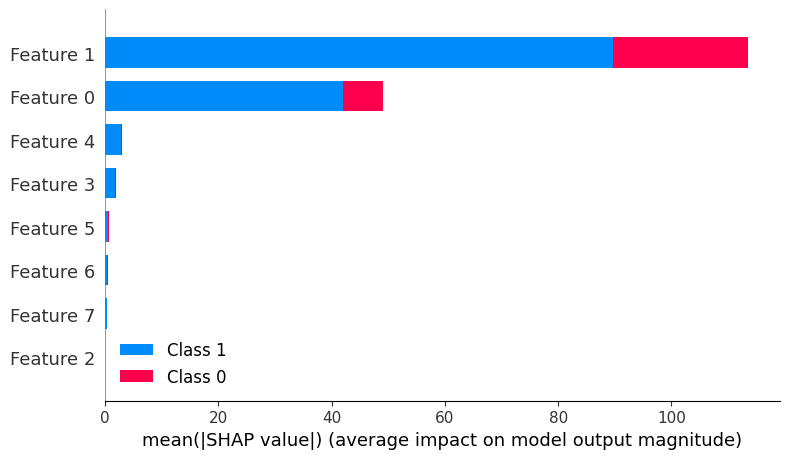

In [64]:
shap.summary_plot(shap_values, x_test_0)

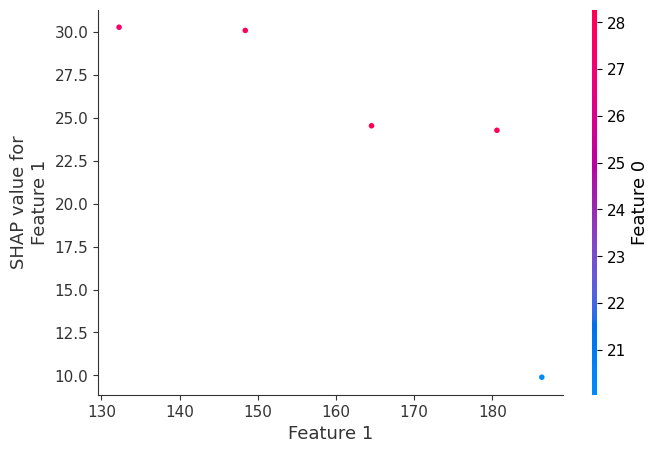

In [65]:
shap.dependence_plot("Feature 1", shap_values[0], x_test_0)

### Lime-For-Time

In [33]:
num_background = 50
num_test = 28
background_data, test_data = x_train[:num_background], x_test[num_test:num_test+2]

In [44]:
import logging
import numpy as np

from sklearn.pipeline import Pipeline

from sktime.classification.interval_based import TimeSeriesForestClassifier

from sktime.transformations.panel.compose import ColumnConcatenator

import matplotlib.pyplot as plt

from lime import explanation
from lime import lime_base
import explainers.lime_timeseries as lime_ts

In [85]:
def testlime(signal_names, clf, x, exclass1, exclass2, labelId):
    class_names=[exclass1, exclass2]

    num_slices=20
    num_features=10

    explainer = lime_ts.LimeTimeSeriesExplainer(class_names=class_names,
                                                signal_names=signal_names)

    labelid = labelId
    exp = explainer.explain_instance(x, clf.predict, num_features=num_features, num_samples=100, num_slices=num_slices, labels=[labelid], replacement_method='total_mean')
    exp.as_pyplot_figure(labelid)
    plt.show()

4/4 [==============================] - 0s 5ms/step


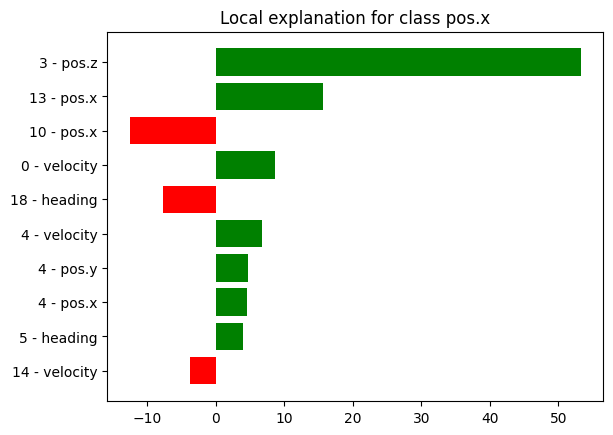

In [88]:
testlime(["pos.x", "pos.y", "pos.z", "heading", "velocity", "weather", "Minute sin", "Minute cos"], model, x_test[0], "pos.x", "pos.y", 0)

4/4 [==============================] - 0s 4ms/step


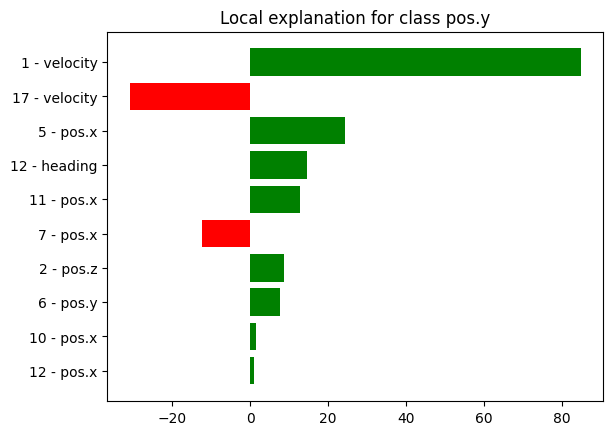

In [86]:
testlime(["pos.x", "pos.y", "pos.z", "heading", "velocity", "weather", "Minute sin", "Minute cos"], model, x_test[0], "pos.x", "pos.y", 1)